In [1]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from torch.utils.data import Dataset
np.set_printoptions(6)
import albumentations as A
import math

# Dataset

For this assignment, we will use the Flowers Dataset from [Harvard Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/1ECTVN#). The dataset is in the public domain, and therefore, we can use it for our work with no restrictions. For convenience, you can download the dataset from D2L. First, download the dataset Zip file from the D2L, upload it to the GoogleColab and unzip it using the following command.



In [2]:
# this cell is NOT USED: very slow speed
# from google.colab import files
# uploaded = files.upload()
# ! unzip -qq FlowerData.zip 

In [3]:
from google.colab import drive
drive.mount('/content/drive')
!echo "Going to UNZIP file"
!ls "/content/drive/MyDrive/UC COURSES/599.6 - deep learning for vision/a1/"
!unzip -qq "/content/drive/MyDrive/UC COURSES/599.6 - deep learning for vision/a1/FlowerData.zip"
!echo "File has been unzipped"
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Going to UNZIP file
FlowerData.zip
replace FlowerData/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
File has been unzipped
drive  FlowerData  sample_data


### 1. Complete the **FlowerDataset** class. There are TODOs that need to be completed. (20 points)


In [4]:
class FlowerDataset(Dataset):
  def __init__(self, root, transform=None, ext='.jpg'):
    """ Instantiate an object of the FlowerDataset
    Args:
      root (str): The root directory includes images, where each class of images is
        inside a separate folder.
      transformation (callable): A image augmentation function to be applied to an image.
        default is None, indicating the there will be no transformation applied
        an image. 
    """
    self.paths = []
    self.labels = []
    self.label_encoder = {"daisy": 0, "dandelion": 1, "roses": 2,
                          "sunflowers": 3, "tulips": 4}
    self.label_decoder = {0: "daisy", 1: "dandelion", 2: "roses",
                          3: "sunflowers", 4: "tulips"}
    # TODO: Read the path to all images and indicat their classes.
    # Hint: You can use glob.glob(f'{directory_path}/**/*.jpg', recursive=True)
    #       to read all images with .jpg file extension inside a directory_path
    #       Also, you can use te self.label_encoder to assign a numerical label
    #       to each flower class
    for path in glob.glob(f'{root}/**/*{ext}', recursive=True):
      self.paths.append(path) # add path of image
      pdir = os.path.basename(os.path.dirname(path)) # parent dir of image file path is the 'label'
      self.labels.append(self.label_encoder[pdir])

    # End of TODO
    assert len(self.paths) == len(self.labels), "Number of image paths and labels should be equal"

    self.transform = transform if transform is not None else lambda x: x
    

  def __len__(self):
    """ Return the number of samples within the dataset """
    #TODO: replace return 0 with the proper code for implementing the requested functionality
    return len(self.labels)

  def __getitem__(self, i):
    """ This method return a tuple made of the i-th element of the dataset, i.e. (image, label).
    
    If the transofrm is not None, you should apply the transform function to the image."""
    #TODO: write code for implementing the requested functionality
    if i < 0 or i >= len(self.labels): return None
    label = self.label_decoder[self.labels[i]]
    path = self.paths[i]
    # read the image
    image = plt.imread(path)
    return self.transform(image), label


###2. The uploaded file contains 3 folders: *train*, *validation*, and *test*. using data from the *validation* and *test* folder create `validation_dataset` and `test_dataset` such that there is no transformation applied to `validation_dataset`, and `test_dataset`. (10 points)

In [5]:
# TODO: replace None with proper code
validation_dataset = FlowerDataset(root="FlowerData/validation")
test_dataset = FlowerDataset(root="FlowerData/test")
len(validation_dataset), len(test_dataset)

(80, 50)

### 3. Plot the first image of the `validation_dataset`, and `test_dataset`. The label of the image should be the title for the plot. (10 points)

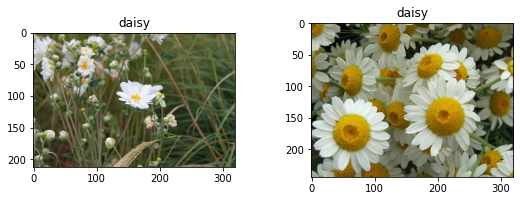

In [6]:
#TODO: Add the code here
def visualize(image_and_label):
  image, label = image_and_label
  plt.figure()
  plt.imshow(image)
  plt.title(str(label))
def visualize_multi(images_and_labels, cols=5):
  tot = len(images_and_labels)
  if tot == 1:
    visualize(images_and_labels[0])

  assert isinstance(cols,int) and cols > 0
  rows = math.ceil(tot/cols)

  fig = plt.figure(figsize=(20,20))

  for i in range(tot):
      image, label = images_and_labels[i]
      fig.add_subplot(rows, cols, i+1)
      plt.imshow(image)
      plt.title(str(label))

  fig.tight_layout(pad=5.0)

  plt.show()
# visualize(validation_dataset[0]), visualize(test_dataset[0])
visualize_multi([validation_dataset[0], test_dataset[0]])

#### 4. (A) Define a comprehensive pipeline designed to increase data variability. You should compose a pipeline including at least 10 image transformations from the `Albumentations` package or from `torchvision.transforms`.  (10 points)

#### (B) Using data from the train folder create `train_dataset`. The `train_dataset` should use the tranformation defined in part (A).  (5 points)

#### (C) Explain how the probabilities for applying each transformation affect the variability of images generated through `__getitem__` method of the `train_dataset`.  (5 points)

#### (D) Visualize the first image of the `train_dataset` for 10 times and observe the varibilities resulted from applying the used transformation. Describe your observation. Can you distingoush the flower types of these transformed images. If not what would you do about it.  (5 points)


In [7]:
# (A)
#TODO: Replace None with an image augmentation pipeline using Albumentations package or torchvision.transforms
# SOURCE: https://albumentations.ai/docs/examples/example/
train_transform = lambda image: A.Compose([
    A.RandomRotate90(),
    A.Flip(),
    A.Transpose(),
    A.OneOf([
        A.IAAAdditiveGaussianNoise(),
        A.GaussNoise(),
    ], p=0.2),
    A.OneOf([
        A.MotionBlur(p=.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
    A.OneOf([
        A.OpticalDistortion(p=0.3),
        A.GridDistortion(p=.1),
        A.IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    A.OneOf([
        A.CLAHE(clip_limit=2),
        A.IAASharpen(),
        A.IAAEmboss(),
        A.RandomBrightnessContrast(),            
    ], p=0.3),
    A.HueSaturationValue(p=0.3),
])(image=image)['image']

In [8]:
# (B) TODO: Using data from the train folder create train_dataset. The train_dataset
#       should use the defined tranformation, i.e. train_transoform to augment
#       each image.
train_dataset = FlowerDataset(root="FlowerData/train", transform=train_transform)

### Answer for (C):
The `albumentations` library was used to create a pipeline of composed functions. The pipeline was extracted from the provided source (as cited) to experiment with train dataset.  

The probabilities distributions are set to lower values. This is to ensure that not all transformations are applied to the image, which may result in a very different image and could affect the model. For example, it is not ideal to always blur an image or alter too its colors. That might affect the quality of the model to train in future.

Therefore, the images are expected to vary by some amount but not a very large extent. Some functions are always forced to be applied. For isntance rotation and flips are applied as the model should output the same label regardless of these such variations in the image.**bold text**

/usr/local/lib/python3.8/dist-packages/albumentations/imgaug/transforms.py:263: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.8/dist-packages/albumentations/imgaug/transforms.py:301: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)
/usr/local/lib/python3.8/dist-packages/albumentations/imgaug/transforms.py:233: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.8/dist-packages/albumentations/imgaug/transforms.py:176: FutureWarning: This augmentation is deprecated. Please use Emboss instead
  warnings.warn("This augmentation is deprecated. Please use Embo

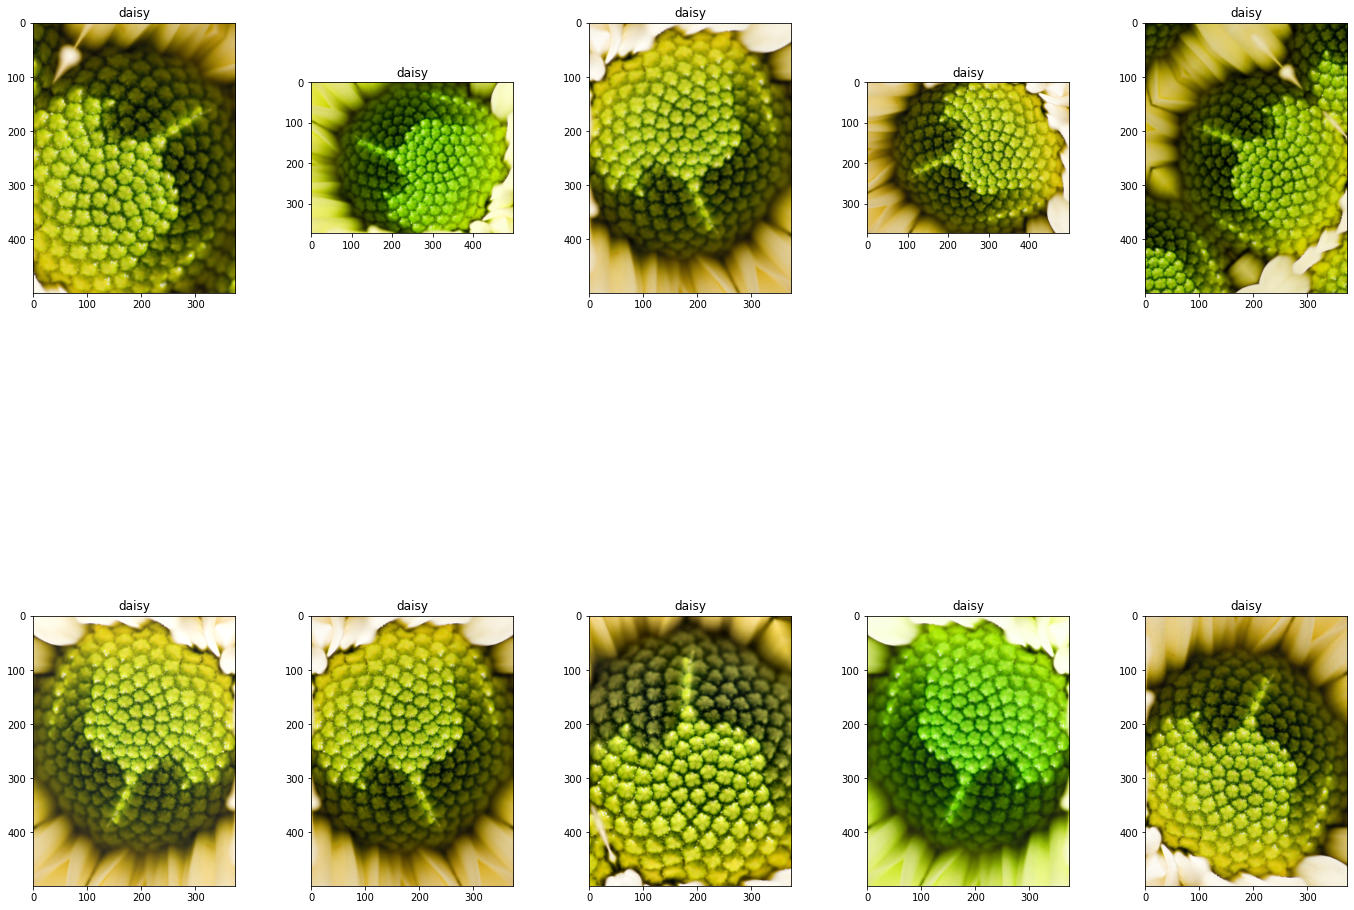

In [9]:
#(D) TODO: Complete visualization here
train_samples = [train_dataset[0] for _ in range(10)]
visualize_multi(train_samples)

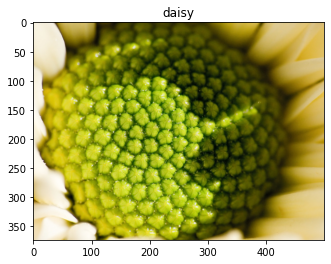

In [10]:
original_image = visualize((plt.imread(train_dataset.paths[0]),'daisy'))

## Review: Answer for (D)
We can notice that overall the image is still mantain the same properties of **daisy** type of flower, regardless of the transformations applied.
Although one possible missing augmentation is variation in brightness and/or light. The amount of variation is not significant enough.

A possible workaround for this might be to modify the **train_transform** function. Either probability can be increased or another function can be added to the composition to make more significant brightness changes.

# Neural Network
Abstract classes allow us to share functionality with any class that extends them. They also allow us to enforce subclasses to implement some functionality. We regularly extend different classes for these purposes. Note that you cannot instantiate an object using an abstract class.

#### 5. Below we define *Module* as an abstract class. For this assignment, any class that implements *Module* should implement a **forward** and a **backward** method.
- **forward**: The forward method should calculate the output given an input
- **backward**: The backward method should calculate the gradient during the backward pass 

We want you to complete the implementation for two modules:
1. Linear: Representing a fully connected layer without any nonlinearity
2. Sigmoid: Representing the sigmoid function that we implemented during the lectures

In forward and backward methods of the **Linear** and **Sigmoid** modules, there are some TODO items that you need to complete. Note that you need to keep the *Module* class unchanged. (35 points)

In [ ]:
# Keep unchanged
class Module(ABC):
    def __init__(self):
        self.num_forward_without_backward = 0
    
    @abstractmethod
    def forward(self, x):
        pass
    
    @abstractmethod
    def backward(self, du):
        pass
    
    def backward_check(self,):
        if self.num_forward_without_backward < 1:
            raise  RuntimeError(
                '''Backward was requested before a forward pass (or multiple times).
            Remember in the backward pass, the gradient of the forward operation is
            calculated. Therefore, backward should happen after forward.'''
            )
            
        elif self.num_forward_without_backward > 1:
            raise  RuntimeError(
                '''Backward was requested after several forward passes.
            In this assignment, modules have a cache variable that helps them
            to calculate the gradient of the last forward pass. They can not 
            handle backward pass of multiple forward passes.
            To solve this issue, instead of calling the forward pass
            an instance, for example sigmoid, several times, create mutiple instances
            and call the forward once for each one of them.'''
                               )
        else:
            return True

## Linear Class (Layer With Trainable Parameters)

In [ ]:
class Linear(Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.cache = None
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # TODO: Create the weights matrix (parameters) and bias

        # END of TODO

        self.dweight = np.empty_like(self.weight)
        self.dbias = np.empty_like(self.bias)
        self.parameters_dict = {'weight':('weight', 'dweight'),
                                'bias':('bias', 'dbias')}
                            
    def forward(self, x):
        self.num_forward_without_backward += 1
        
        # TODO: Implement the forward method for the Linear Module
        
        # END of TODO

        
    def backward(self, du):
        self.backward_check()
        self.num_forward_without_backward -= 1

        # TODO: Implement the backward method for the Linear Module
        
        # END of TODO

## Sigmoid (Activation Function)

In [ ]:
class Sigmoid(Module):
    def __init__(self):
        super().__init__()
        self.cache = None
        
    def forward(self, x):
        self.num_forward_without_backward += 1
        
        # TODO: Implement the forward method for the Sigmoid Module
        #       Note that the input to Sigmoid could be a vector
        
        # END of TODO
        
    def backward(self, du):
        self.backward_check()
        self.num_forward_without_backward -= 1
        
        # TODO: Implement the backward method for the Sigmoid Module
        
        # END of TODO

Write some test cases to show that your code is working as it should.